In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-04-30 23:51:21.217122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 23:51:21.217150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-04-30 23:51:24.068277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 23:51:24.068305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 23:51:24.068325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-04-30 23:51:24.068521: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 2s 3ms/step - loss: 0.6894 - accuracy: 0.5071 - auc: 0.5741 - val_loss: 0.6748 - val_accuracy: 0.5225 - val_auc: 0.6792
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6796 - accuracy: 0.5192 - auc: 0.6233 - val_loss: 0.6684 - val_accuracy: 0.5275 - val_auc: 0.7480
Epoch 3/41
391/391 [==============================] - 3s 8ms/step - loss: 0.6732 - accuracy: 0.5327 - auc: 0.6507 - val_loss: 0.6629 - val_accuracy: 0.5376 - val_auc: 0.7941
Epoch 4/41
391/391 [==============================] - 3s 7ms/step - loss: 0.6676 - accuracy: 0.5447 - auc: 0.6736 - val_loss: 0.6572 - val_accuracy: 0.5533 - val_auc: 0.8270
Epoch 5/41
391/391 [==============================] - 2s 4ms/step - loss: 0.6613 - accuracy: 0.5587 - auc: 0.6981 - val_loss: 0.6510 - val_accuracy: 0.5810 - val_auc: 0.8477
Epoch 6/41
391/391 [==============================] - 2s 5ms/step - loss: 0.6558 - accuracy: 0.5759 - auc: 0.7140 - val_loss: 0.6443 - val_ac

391/391 [==============================] - 1s 2ms/step - loss: 0.6322 - accuracy: 0.6396 - auc: 0.7601 - val_loss: 0.6109 - val_accuracy: 0.7527 - val_auc: 0.8954
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6171 - accuracy: 0.6686 - auc: 0.7788 - val_loss: 0.5903 - val_accuracy: 0.7876 - val_auc: 0.9067
Epoch 7/41
391/391 [==============================] - 1s 2ms/step - loss: 0.6005 - accuracy: 0.6927 - auc: 0.7942 - val_loss: 0.5678 - val_accuracy: 0.8203 - val_auc: 0.9156
Epoch 8/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5819 - accuracy: 0.7137 - auc: 0.8082 - val_loss: 0.5442 - val_accuracy: 0.8371 - val_auc: 0.9237
Epoch 9/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5619 - accuracy: 0.7324 - auc: 0.8214 - val_loss: 0.5166 - val_accuracy: 0.8464 - val_auc: 0.9312
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5406 - accuracy: 0.7472 - auc: 0.8349 - val_loss: 0.4923 - val_a

391/391 [==============================] - 2s 4ms/step - loss: 0.5128 - accuracy: 0.7620 - auc: 0.8502 - val_loss: 0.4522 - val_accuracy: 0.8666 - val_auc: 0.9470
Epoch 10/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4913 - accuracy: 0.7728 - auc: 0.8601 - val_loss: 0.4282 - val_accuracy: 0.8676 - val_auc: 0.9506
Epoch 11/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4707 - accuracy: 0.7828 - auc: 0.8699 - val_loss: 0.4032 - val_accuracy: 0.8720 - val_auc: 0.9539
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4526 - accuracy: 0.7919 - auc: 0.8781 - val_loss: 0.3841 - val_accuracy: 0.8713 - val_auc: 0.9563
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4406 - accuracy: 0.7963 - auc: 0.8828 - val_loss: 0.3722 - val_accuracy: 0.8680 - val_auc: 0.9578
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4274 - accuracy: 0.8031 - auc: 0.8890 - val_loss: 0.3578 - v

391/391 [==============================] - 1s 4ms/step - loss: 0.5720 - accuracy: 0.7260 - auc: 0.8086 - val_loss: 0.5583 - val_accuracy: 0.7972 - val_auc: 0.9008
Epoch 14/84
391/391 [==============================] - 2s 4ms/step - loss: 0.5634 - accuracy: 0.7324 - auc: 0.8147 - val_loss: 0.5466 - val_accuracy: 0.8027 - val_auc: 0.9075
Epoch 15/84
391/391 [==============================] - 1s 4ms/step - loss: 0.5525 - accuracy: 0.7410 - auc: 0.8234 - val_loss: 0.5345 - val_accuracy: 0.8070 - val_auc: 0.9135
Epoch 16/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5442 - accuracy: 0.7430 - auc: 0.8272 - val_loss: 0.5236 - val_accuracy: 0.8094 - val_auc: 0.9190
Epoch 17/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5333 - accuracy: 0.7524 - auc: 0.8354 - val_loss: 0.5114 - val_accuracy: 0.8134 - val_auc: 0.9241
Epoch 18/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5237 - accuracy: 0.7569 - auc: 0.8412 - val_loss: 0.4981 - v

Epoch 60/84
391/391 [==============================] - 1s 4ms/step - loss: 0.3552 - accuracy: 0.8391 - auc: 0.9233 - val_loss: 0.3242 - val_accuracy: 0.8561 - val_auc: 0.9650
Epoch 61/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3542 - accuracy: 0.8406 - auc: 0.9237 - val_loss: 0.3277 - val_accuracy: 0.8521 - val_auc: 0.9651
Epoch 62/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3542 - accuracy: 0.8401 - auc: 0.9237 - val_loss: 0.3253 - val_accuracy: 0.8542 - val_auc: 0.9651
Epoch 63/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3532 - accuracy: 0.8386 - auc: 0.9243 - val_loss: 0.3310 - val_accuracy: 0.8493 - val_auc: 0.9652
Epoch 64/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3529 - accuracy: 0.8403 - auc: 0.9245 - val_loss: 0.3301 - val_accuracy: 0.8500 - val_auc: 0.9653
Epoch 65/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3534 - accuracy: 0.8394 - auc: 0.9240 - val_loss

391/391 [==============================] - 1s 3ms/step - loss: 0.4438 - accuracy: 0.7953 - auc: 0.8824 - val_loss: 0.3798 - val_accuracy: 0.8658 - val_auc: 0.9596
Epoch 22/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4358 - accuracy: 0.7990 - auc: 0.8863 - val_loss: 0.3719 - val_accuracy: 0.8641 - val_auc: 0.9608
Epoch 23/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4290 - accuracy: 0.8011 - auc: 0.8894 - val_loss: 0.3635 - val_accuracy: 0.8661 - val_auc: 0.9617
Epoch 24/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4209 - accuracy: 0.8061 - auc: 0.8938 - val_loss: 0.3543 - val_accuracy: 0.8689 - val_auc: 0.9624
Epoch 25/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4161 - accuracy: 0.8074 - auc: 0.8956 - val_loss: 0.3491 - val_accuracy: 0.8672 - val_auc: 0.9628
Epoch 26/84
391/391 [==============================] - 2s 4ms/step - loss: 0.4097 - accuracy: 0.8119 - auc: 0.8987 - val_loss: 0.3438 - v

Epoch 68/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3397 - accuracy: 0.8481 - auc: 0.9302 - val_loss: 0.3152 - val_accuracy: 0.8555 - val_auc: 0.9659
Epoch 69/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3364 - accuracy: 0.8500 - auc: 0.9316 - val_loss: 0.3132 - val_accuracy: 0.8571 - val_auc: 0.9659
Epoch 70/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3359 - accuracy: 0.8496 - auc: 0.9318 - val_loss: 0.3174 - val_accuracy: 0.8540 - val_auc: 0.9660
Epoch 71/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3371 - accuracy: 0.8495 - auc: 0.9310 - val_loss: 0.3181 - val_accuracy: 0.8539 - val_auc: 0.9660
Epoch 72/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3369 - accuracy: 0.8493 - auc: 0.9313 - val_loss: 0.3190 - val_accuracy: 0.8521 - val_auc: 0.9661
Epoch 73/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3351 - accuracy: 0.8494 - auc: 0.9321 - val_loss

391/391 [==============================] - 1s 3ms/step - loss: 0.3850 - accuracy: 0.8236 - auc: 0.9102 - val_loss: 0.3130 - val_accuracy: 0.8737 - val_auc: 0.9641
Epoch 30/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8266 - auc: 0.9127 - val_loss: 0.3095 - val_accuracy: 0.8745 - val_auc: 0.9642
Epoch 31/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8283 - auc: 0.9136 - val_loss: 0.3088 - val_accuracy: 0.8741 - val_auc: 0.9644
Epoch 32/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3767 - accuracy: 0.8285 - auc: 0.9142 - val_loss: 0.3111 - val_accuracy: 0.8705 - val_auc: 0.9644
Epoch 33/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3735 - accuracy: 0.8305 - auc: 0.9156 - val_loss: 0.3073 - val_accuracy: 0.8737 - val_auc: 0.9644
Epoch 34/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3728 - accuracy: 0.8305 - auc: 0.9163 - val_loss: 0.3072 - v

Epoch 76/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3289 - accuracy: 0.8536 - auc: 0.9345 - val_loss: 0.3229 - val_accuracy: 0.8494 - val_auc: 0.9665
Epoch 77/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3297 - accuracy: 0.8523 - auc: 0.9340 - val_loss: 0.3208 - val_accuracy: 0.8511 - val_auc: 0.9666
Epoch 78/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3263 - accuracy: 0.8542 - auc: 0.9355 - val_loss: 0.3143 - val_accuracy: 0.8551 - val_auc: 0.9667
Epoch 79/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3288 - accuracy: 0.8527 - auc: 0.9344 - val_loss: 0.3158 - val_accuracy: 0.8537 - val_auc: 0.9666
Epoch 80/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3284 - accuracy: 0.8545 - auc: 0.9345 - val_loss: 0.3209 - val_accuracy: 0.8501 - val_auc: 0.9666
Epoch 81/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3271 - accuracy: 0.8539 - auc: 0.9352 - val_loss

Epoch 2/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.3542 - accuracy: 0.8404 - auc: 0.9223 - val_loss: 0.2982 - val_accuracy: 0.8707 - val_auc: 0.9566
Epoch 3/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.3477 - accuracy: 0.8432 - auc: 0.9253 - val_loss: 0.2807 - val_accuracy: 0.8760 - val_auc: 0.9555
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.2806282937526703, 'epoch': 1}, 'best_auc': {'auc': 0.9568955302238464, 'epoch': 1}, 'best_accuracy': {'accuracy': 0.8826500177383423, 'epoch': 1}}
Epoch 1/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.5842 - accuracy: 0.6804 - auc: 0.7751 - val_loss: 0.4147 - val_accuracy: 0.8487 - val_auc: 0.9455
Epoch 2/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.4283 - accuracy: 0.7974 - auc: 0.8843 - val_loss: 0.3196 - val_accuracy: 0.8696 - val_auc: 0.9616
Epoch 3/4
12512/12512 [=======================

Epoch 6/7
12512/12512 [==============================] - 40s 3ms/step - loss: 0.3903 - accuracy: 0.8277 - auc: 0.9089 - val_loss: 0.3134 - val_accuracy: 0.8684 - val_auc: 0.9489
Epoch 7/7
12512/12512 [==============================] - 33s 3ms/step - loss: 0.3867 - accuracy: 0.8295 - auc: 0.9106 - val_loss: 0.3256 - val_accuracy: 0.8628 - val_auc: 0.9477
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.3133549988269806, 'epoch': 6}, 'best_auc': {'auc': 0.9504504203796387, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.869700014591217, 'epoch': 5}}
Epoch 1/7
12512/12512 [==============================] - 26s 2ms/step - loss: 0.4227 - accuracy: 0.8042 - auc: 0.8903 - val_loss: 0.3367 - val_accuracy: 0.8507 - val_auc: 0.9475
Epoch 2/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.3998 - accuracy: 0.8211 - auc: 0.9034 - val_loss: 0.3227 - val_accuracy: 0.8539 - val_auc: 0.9466
Epoch 3/7
12512/12512 [========================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 25s 2ms/step - loss: 0.4021 - accuracy: 0.8173 - auc: 0.8998 - val_loss: 0.2874 - val_accuracy: 0.8740 - val_auc: 0.9521
Epoch 2/3
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3828 - accuracy: 0.8347 - auc: 0.9084 - val_loss: 0.2832 - val_accuracy: 0.8760 - val_auc: 0.9519
Epoch 3/3
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3794 - accuracy: 0.8383 - auc: 0.9106 - val_loss: 0.2807 - val_accuracy: 0.8787 - val_auc: 0.9537


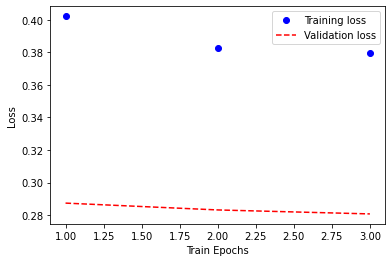

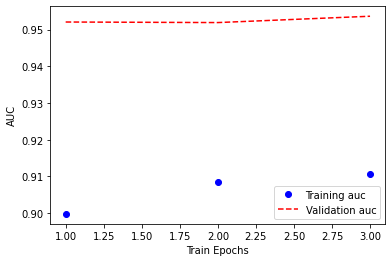

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

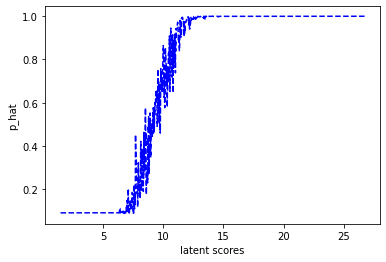

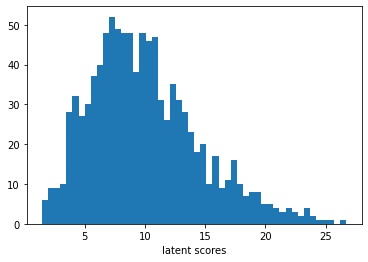

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

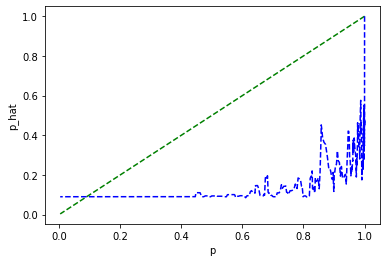

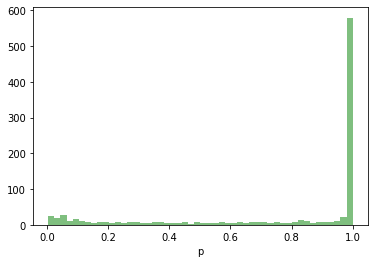

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

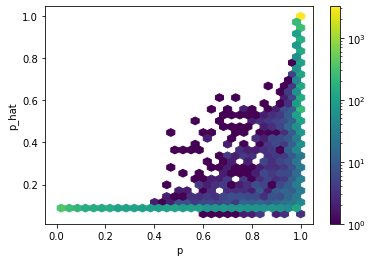

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

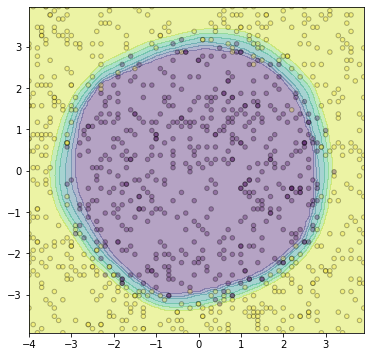

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.2743813097476959, 'epoch': 3},
 'best_auc': {'auc': 0.9524732828140259, 'epoch': 3},
 'best_accuracy': {'accuracy': 0.8865500092506409, 'epoch': 3},
 'model': <keras.engine.sequential.Sequential at 0x7f3d5c533fa0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.3287423849105835, 'epoch': 36},
  'best_auc': {'auc': 0.9640999436378479, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.8677499890327454, 'epoch': 27}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.3275689482688904, 'epoch': 30},
  'best_auc': {'auc': 0.9655686616897583, 'epoch': 40},
  'best_accuracy': {'accuracy': 0.8672000169754028, 'epoch': 19}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.3224763572216034, 'epoch': 25},
  'best_auc': {'auc': 0.9643856287002563, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.871999979019165, 'epoch': 11}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.3242141306400299, 'epoch': 60},
  'best_auc': {'auc': 0.9659695625305176, 'epoch': 82},
  'best_accuracy':

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25